# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

Below are some helper functions to help code readability

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8, draw_variance=False):
    """    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    coord_x = img.shape[1]
    coord_y = img.shape[0]
    right_xpoints = []
    right_ypoints = []
    left_ypoints = []
    left_xpoints = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            a, b = np.polyfit([x1,x2], [y1,y2], 1)
            if abs(a)>0.5:
                if ((x1+x2)/2 > coord_x/2):
                    right_xpoints.append(x1)
                    right_ypoints.append(y1)
                    right_xpoints.append(x2)
                    right_ypoints.append(y2)
                else:
                    left_xpoints.append(x1)
                    left_ypoints.append(y1)
                    left_xpoints.append(x2)
                    left_ypoints.append(y2)
    
    if right_xpoints != [] and right_ypoints != []:
        if len(right_xpoints) > 2 and draw_variance:
            p, V = np.polyfit(right_xpoints, right_ypoints, 1, cov=True)
            a, b = p
            img = cv2.line(img, (0, int(b)), (int((coord_y-1-(b+V[1,1]**0.5))/a), coord_y-1), color, thickness)
            img = cv2.line(img, (0, int(b)), (int((coord_y-1-(b-V[1,1]**0.5))/a), coord_y-1), color, thickness)
        else:
            a, b = np.polyfit(right_xpoints, right_ypoints, 1)
        img = cv2.line(img, (0, int(b)), (int((coord_y-1-b)/a), coord_y-1), color, thickness)
        
    if left_xpoints != [] and left_ypoints != []:
        if len(left_xpoints) > 2 and draw_variance:
            p, V = np.polyfit(left_xpoints, left_ypoints, 1, cov=True)
            a, b = p
            img = cv2.line(img, (int(-b/a), 0), (int((coord_y-1-(b+V[1,1]**0.5))/a), coord_y-1), color, thickness)
            img = cv2.line(img, (int(-b/a), 0), (int((coord_y-1-(b-V[1,1]**0.5))/a), coord_y-1), color, thickness)
        else:
            a, b = np.polyfit(left_xpoints, left_ypoints, 1)
        img = cv2.line(img, (int(-b/a), 0), (int((coord_y-1-b)/a), coord_y-1), color, thickness)
            
    return img
                

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline



Briefly, the pipeline consist of filtering operations to make a image with almost just the lanes on it. Then, Canny Edge algorithm followed by HoughTransform to detect the lines and finally draw them.

In [4]:
def process_image(image, debug=False):
    
    # Filter white and yellow colors
    white = cv2.inRange(image, (200, 200, 200), (255, 255, 255))
    yellow = cv2.inRange(image, (180, 180, 0), (255, 255, 150))
    binary = white + yellow
    
    if debug:
        images.append(binary.copy())
        titles.append('Binary')

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(binary, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    imshape = image.shape
    vertices = np.array([[(imshape[1]*0.07,imshape[0]),
                          (imshape[1]*0.45, 1.2*imshape[0]/2),
                          (imshape[1]*0.55, 1.2*imshape[0]/2),
                          (imshape[1]*0.93,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    if debug:
        images.append(masked_edges.copy())
        titles.append('Edges')
        
    # Define the Hough transform parameters
    rho = 1             # distance resolution in pixels of the Hough grid
    theta = 6*np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 7       # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 10   # minimum number of pixels making up a line
    max_line_gap = 12   # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Draw the lines on the original image
    line_img = np.zeros((masked_edges.shape[0], masked_edges.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    line_image = region_of_interest(line_image, vertices)    
    result = weighted_img(line_image, image)
    
    return result

## Test Images

The pipeline is first tested on the images in the directory "test_images" which is loaded and shown below

In [5]:
import os
files = os.listdir("test_images/")
files

['solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg']

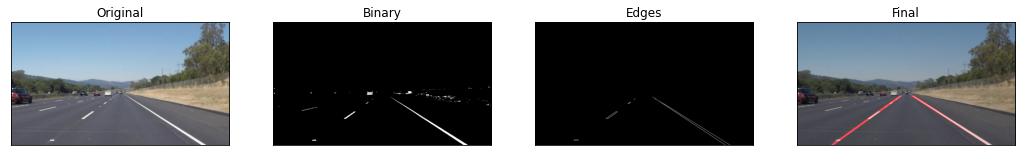

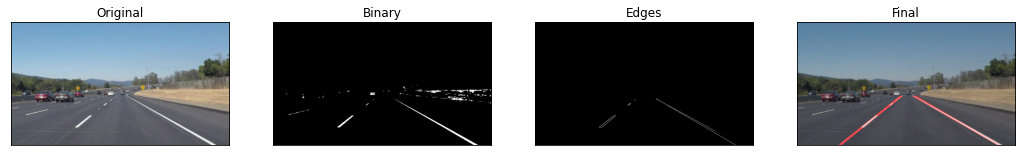

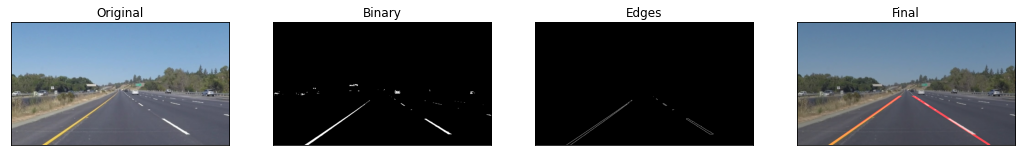

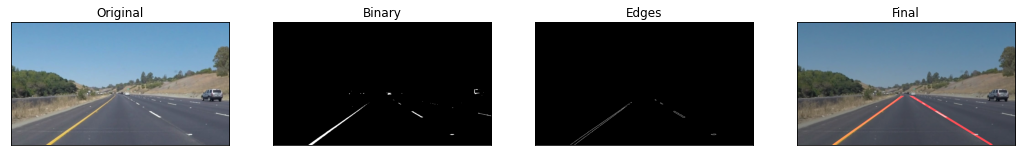

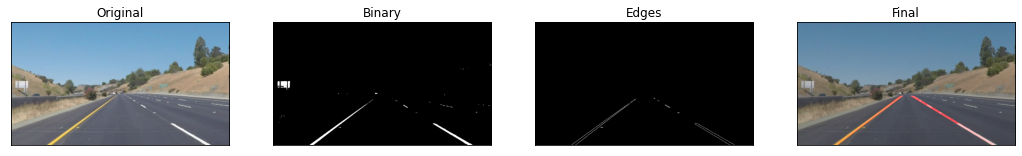

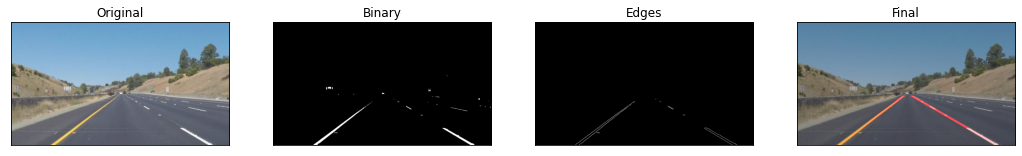

In [6]:
for image_name in files:
    # Create a Figure and arrays to show the images from this image
    plt.figure(image_name, figsize=(18, 6))
    images = []
    titles = []
    
    # Read in the image
    image = mpimg.imread("test_images/" + image_name)
    
    # Show the original image
    images.append(image.copy())
    titles.append('Original')
    
    final = process_image(image, debug=True)
    
    # Show the final image
    images.append(final.copy())
    titles.append('Final')
    
    # Save image
    cv2.imwrite('test_images_output/' + image_name, cv2.cvtColor(final, cv2.COLOR_RGB2BGR))
    
    # Show the result images
    for j in range(len(images)):
        if images[j].shape[-1] != 3:
            plt.subplot(1, len(images), j+1), plt.imshow(images[j], 'gray')
        else:
            plt.subplot(1, len(images), j+1), plt.imshow(images[j])
        plt.title(titles[j])
        plt.xticks([]),plt.yticks([])



## Test on Videos

After passing images tests succefully, next step it to test the pipeline on videos

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   3%|▎         | 7/221 [00:00<00:03, 62.96it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 5.46 s, sys: 579 ms, total: 6.04 s
Wall time: 9.27 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|          | 5/681 [00:00<00:13, 49.11it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 17.7 s, sys: 1.46 s, total: 19.1 s
Wall time: 29 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Challenge Test

The videos were are all right. So, time to evaluate how the pipeline performs at a noisy environment with a curve.

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   2%|▏         | 4/251 [00:00<00:07, 35.11it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 10.3 s, sys: 1.84 s, total: 12.1 s
Wall time: 24.5 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))